<strong>Text minining assignment</strong>
1. 청원 최신 데이터 크롤링
2. 청원 제목 KoNLpy로 전처리 후 wordcloud 구현하기 
3. 특정 키워드(백신)로 word2vec 단어 유사도 보기
4. bag of word 및 tf-idf 

# 최신 청원 데이터 크롤링

## set up

In [88]:
## install library
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdrㅠiver.common.keys import Keys

import time
import re
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

options = webdriver.ChromeOptions()
options.add_argument('headless')

import warnings
warnings.filterwarnings('ignore')

주어진 데이터 확인

In [99]:
df=pd.read_csv('petition.csv')
df.head()

,article_id,start,end,answered,votes,category,title,content
0,21,2017-08-19,2017-11-17,0,9,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...
1,22,2017-08-19,2017-11-17,0,17,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...
2,23,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."
3,24,2017-08-19,2017-08-26,0,53,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...
4,25,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."


In [228]:
#category, title, end, votes만 뽑아 사용
#최신 데이터와 결합하여 분석 진행
petition_old=pd.concat([df[['category']],df[['title']],df[['end']], df[['votes']], df[['content']]],axis=1)

현재 진행 중인 청원과 만료된 청원 나누어 크롤링 진행

## 진행 중 청원

In [277]:
#셀레니움 드라이버 
driver=webdriver.Chrome(r'/Users/hwangjaewon/Desktop/chromedriver')

In [278]:
## 진행 중인 청원 크롤링
def petition_crawling(start, end): #몇페이지를 크롤링할 것인지
    taken_time=time.time()
    for page in range(start,end+1,1):
        url = 'https://www1.president.go.kr/petitions/?c=0&only=1&page='+str(page)+'&order=2'
        driver.implicitly_wait(10)
        driver.get(url)
        time.sleep(2.5)
        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')
        #한 페이지 정보 불러오기
        petition_list = soup.find('ul', attrs = {'class' : 'petition_list'})
        for i in range(7):
            category.append( petition_list.select("div.bl_category.ccategory.cs.wv_category")[i].span.next_sibling )
            title.append( petition_list.select("div.bl_subject")[i].span.next_sibling )
            exp_date.append( petition_list.select("div.bl_date.light")[i].span.next_sibling )
            participate.append( petition_list.select("div.bl_agree.cs")[i].span.next_sibling ) 
            url_.append( petition_list.select("div.bl_subject")[i].a.get('href') )
    print(time.time()-taken_time)

In [ ]:
#정보 담을 빈 리스트 만들기
category = []; title = []; exp_date = []; participate = []; url_ = []

## 진행 중인 청원은 93페이지까지 존재
petition_crawling(1,93) 

In [281]:
data1 = pd.DataFrame({'category' : category, 'title' : title, 'end' : exp_date, 'votes' : participate, 'url' : url_})
print(data1.shape)
data1 
data1.to_csv('진행중청원.csv')

(644, 5)


,category,title,end,votes,url
0,보건복지,백신패스(일명 방역패스) 다시 한 번 결사 반대합니다,2021-12-26,"334,073명",/petitions/602510
1,정치개혁,"연일보도중인 ""층간소음 살인미수사건""경찰대응문제로 인천 **경찰서를 고발합니다.이건...",2021-12-21,"255,671명",/petitions/602400
2,인권/성평등,외국 국적 여중생을 묶고 6시간 가학적 집단폭행한 가해자4명 강력처벌.신상공개를촉구...,2022-01-01,"204,644명",/petitions/602674
3,보건복지,아이들까지 백신강요 하지 마세요!,2022-01-05,"117,788명",/petitions/602722
4,반려동물,푸들만 19마리 입양 ! 온갖고문으로 잔혹학대 후 죽이고 불법매립한 범죄자의 강력한...,2022-01-06,"85,355명",/petitions/602794
...,...,...,...,...,...
639,행정,구미시 **면에 우사가 난립하지 못하도록 막아주십시오,2021-12-30,115명,/petitions/602608
640,교통/건축/국토,불법과속방지턱을 꼭 정비해 주십시요,2022-01-07,115명,/petitions/602823
641,교통/건축/국토,(교통사고) 피해자가 가해자가 되었어요,2022-01-07,113명,/petitions/602824
642,교통/건축/국토,어린이통합차량 구조변경에 관하여,2021-12-29,112명,/petitions/602560


In [282]:
#청원 내용 크롤링
def get_content_1(s,t):
    start = time.time()
    for page in range((s-1),t,1):
        url = 'https://www1.president.go.kr/'+ data1.url[page]
        driver.implicitly_wait(10)
        driver.get(url)
        time.sleep(1)
        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')

        s = soup.find("ul",{"class":"petitionsView_info_list"})
        contents = soup.find("div",{"class":"View_write", "style":'word-break:break-all'}).get_text()
        content1.append( contents )
            
    print(time.time()-start)

In [283]:
content1 = []
get_content_1(1,651)

KeyError: 644

In [289]:
sub_data_1 = pd.DataFrame({'content': content1})
sub_data_1

,content
0,\n\t\t\t\t\t\t\t\t\t\t저는 대구 수성구에 거주하는 2004년생 현...
1,\n\t\t\t\t\t\t\t\t\t\t연일보도되고 있는 층간소음 살인미수 사건으...
2,\n\t\t\t\t\t\t\t\t\t\t외국 국적 여중생을 집단 폭행하고 학대한 또...
3,\n\t\t\t\t\t\t\t\t\t\t오미크론 유입으로 방역 고삐를 좀 조이는가 ...
4,\n\t\t\t\t\t\t\t\t\t\t■ 푸들 19마리를 입양한 후 잃어버렸다?\...
...,...
639,\n\t\t\t\t\t\t\t\t\t\t구미 **면에 지난 몇 년간 거주하고 있는 ...
640,\n\t\t\t\t\t\t\t\t\t\t수고많으십니다.\n\n국토교통부의 도로안전시...
641,\n\t\t\t\t\t\t\t\t\t\t안녕하세요. 저는 안산에 살고 있고 태어나서...
642,\n\t\t\t\t\t\t\t\t\t\t음악학원을 운영하고 있습니다\n기존 차량(9...


In [290]:
sub_data.reset_index(drop=True, inplace=True)
final_data_1 = pd.concat([data1,sub_data_1], axis = 1)
final_data_1.to_csv('진행중 청원_최종.csv') 

## 만료된 청원

In [76]:
## 진행 중인 청원 크롤링
def petition_crawling(start, end): #몇페이지를 크롤링할 것인지
    taken_time=time.time()
    for page in range(start,end+1,1): #url 부분이 다름!
        url = 'https://www1.president.go.kr/petitions/?c=0&only=2&page='+str(page)+'&order=2'
        driver.implicitly_wait(10)
        driver.get(url)
        time.sleep(2.5)
        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')
        #한 페이지 정보 불러오기
        petition_list = soup.find('ul', attrs = {'class' : 'petition_list'})
        for i in range(7):
            category.append( petition_list.select("div.bl_category.ccategory.cs.wv_category")[i].span.next_sibling )
            title.append( petition_list.select("div.bl_subject")[i].span.next_sibling )
            exp_date.append( petition_list.select("div.bl_date.light")[i].span.next_sibling )
            participate.append( petition_list.select("div.bl_agree.cs")[i].span.next_sibling ) 
            url_.append( petition_list.select("div.bl_subject")[i].a.get('href') )
    print(time.time()-taken_time)

In [77]:
category2 = []; title2 = []; exp_date2 = []; participate2= []; url_2 = []

## 만료된 청원 중 500페이지 크롤링 진행
get_info2(1,500)    

IndexError: list index out of range

In [79]:
## 430까지 크롤링되고 오류나서 다시 마저 크롤링
get_info2(431,500) 

210.95855689048767


In [94]:
data2 = pd.DataFrame({'category' : category2, 'title' : title2, 'end' : exp_date2, 'votes'  : participate2, 'url' : url_2})
print(data2.shape)
data2
data2.to_csv('만료청원.csv')

(3500, 5)


,category,title,end,votes,url
0,안전/환경,텔레그램 n번방 용의자 신상공개 및 포토라인 세워주세요,2020-04-17,"2,715,626명",/petitions/586819
1,안전/환경,텔레그램 n번방 가입자 전원의 신상공개를 원합니다,2020-04-19,"2,026,252명",/petitions/586880
2,정치개혁,자유 한국당 정당해산 청원,2019-05-22,"1,831,900명",/petitions/579682
3,기타,문재인 대통령님을 응원 합니다!,2020-03-27,"1,504,597명",/petitions/585683
4,정치개혁,문재인 대통령 탄핵을 촉구합니다.,2020-03-05,"1,469,023명",/petitions/584936
...,...,...,...,...,...
3495,행정,고 ***군 변사심의 위원 외부전문가 추천,2021-07-21,"6,653명",/petitions/599233
3496,교통/건축/국토,고양시에만 gtx역이 왜 3개나 들어가나요? 급행 아니고 지하철인가요?,2021-01-29,"6,652명",/petitions/595144
3497,보건복지,"중국 폐렴, 정부의 조치를 원합니다.",2020-02-21,"6,647명",/petitions/584585
3498,미래,"국민 여러분, 여순10.19특별법 제정 도와주십시오.",2018-11-18,"6,645명",/petitions/411305


In [200]:
driver=webdriver.Chrome(r'/Users/hwangjaewon/Desktop/chromedriver')

In [217]:
## 만료된 청원 크롤링
def get_content_2(s,t):

    start = time.time()
    for page in range((s-1),t,1):
        url = 'https://www1.president.go.kr/'+ data2.url[page]
        driver.implicitly_wait(10)
        driver.get(url)
        time.sleep(1)
        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')

        s = soup.find("ul",{"class":"petitionsView_info_list"})
        contents = soup.find("div",{"class":"View_write", "style":'word-break:break-all'}).get_text()
        content.append( contents )
            
    print(time.time()-start)

In [206]:
content = []
get_content(1,500)

887.2142360210419


In [210]:
get_content(501,3500)

4443.040243864059


In [211]:
sub_data = pd.DataFrame({'content': content})
sub_data 

,contents
0,\n\t\t\t\t\t\t\t\t\t\t오늘 검거되었다고 합니다\n타인의 수치심과 ...
1,"\n\t\t\t\t\t\t\t\t\t\t안녕하세요,\n\n텔레그램 n번방에 대한 수..."
2,\n\t\t\t\t\t\t\t\t\t\t민주당과 정부에 간곡히 청원합니다 자유한국당...
3,\n\t\t\t\t\t\t\t\t\t\t코로나 바이러스19로 인해 대한민국 모든 국...
4,\n\t\t\t\t\t\t\t\t\t\t국민의 한 사람으로서 문재인 대통령의 탄핵을...
...,...
3495,\n\t\t\t\t\t\t\t\t\t\t대학생 한강 변사사건은 국민의 많은 의혹과 ...
3496,\n\t\t\t\t\t\t\t\t\t\t서울 제외하고 하나의 시가 gtx역을 3개나...
3497,\n\t\t\t\t\t\t\t\t\t\t지금 1월20일에 우환 폐렴을 보균한 중국 ...
3498,\n\t\t\t\t\t\t\t\t\t\t“여순10·19특별법 제정” \n국민 여러분...


In [292]:
sub_data.columns=['content']

In [293]:
sub_data.reset_index(drop=True, inplace=True)
final_data_2 = pd.concat([data2,sub_data], axis = 1)
final_data_2.to_csv('만료된 청원_최종.csv') 

In [294]:
final_data_2

,category,title,end,votes,url,content
0,안전/환경,텔레그램 n번방 용의자 신상공개 및 포토라인 세워주세요,2020-04-17,"2,715,626명",/petitions/586819,\n\t\t\t\t\t\t\t\t\t\t오늘 검거되었다고 합니다\n타인의 수치심과 ...
1,안전/환경,텔레그램 n번방 가입자 전원의 신상공개를 원합니다,2020-04-19,"2,026,252명",/petitions/586880,"\n\t\t\t\t\t\t\t\t\t\t안녕하세요,\n\n텔레그램 n번방에 대한 수..."
2,정치개혁,자유 한국당 정당해산 청원,2019-05-22,"1,831,900명",/petitions/579682,\n\t\t\t\t\t\t\t\t\t\t민주당과 정부에 간곡히 청원합니다 자유한국당...
3,기타,문재인 대통령님을 응원 합니다!,2020-03-27,"1,504,597명",/petitions/585683,\n\t\t\t\t\t\t\t\t\t\t코로나 바이러스19로 인해 대한민국 모든 국...
4,정치개혁,문재인 대통령 탄핵을 촉구합니다.,2020-03-05,"1,469,023명",/petitions/584936,\n\t\t\t\t\t\t\t\t\t\t국민의 한 사람으로서 문재인 대통령의 탄핵을...
...,...,...,...,...,...,...
3495,행정,고 ***군 변사심의 위원 외부전문가 추천,2021-07-21,"6,653명",/petitions/599233,\n\t\t\t\t\t\t\t\t\t\t대학생 한강 변사사건은 국민의 많은 의혹과 ...
3496,교통/건축/국토,고양시에만 gtx역이 왜 3개나 들어가나요? 급행 아니고 지하철인가요?,2021-01-29,"6,652명",/petitions/595144,\n\t\t\t\t\t\t\t\t\t\t서울 제외하고 하나의 시가 gtx역을 3개나...
3497,보건복지,"중국 폐렴, 정부의 조치를 원합니다.",2020-02-21,"6,647명",/petitions/584585,\n\t\t\t\t\t\t\t\t\t\t지금 1월20일에 우환 폐렴을 보균한 중국 ...
3498,미래,"국민 여러분, 여순10.19특별법 제정 도와주십시오.",2018-11-18,"6,645명",/petitions/411305,\n\t\t\t\t\t\t\t\t\t\t“여순10·19특별법 제정” \n국민 여러분...


In [287]:
final_data_1.drop(['url'], axis=1, inplace=True)
final_data_2.drop(['url'], axis=1, inplace=True)

KeyError: "['url'] not found in axis"

In [295]:
petition_new=pd.concat([final_data_1, final_data_2], axis=0)
petition_new.head()

,category,title,end,votes,url,content
0,보건복지,백신패스(일명 방역패스) 다시 한 번 결사 반대합니다,2021-12-26,"334,073명",/petitions/602510,\n\t\t\t\t\t\t\t\t\t\t저는 대구 수성구에 거주하는 2004년생 현...
1,정치개혁,"연일보도중인 ""층간소음 살인미수사건""경찰대응문제로 인천 **경찰서를 고발합니다.이건...",2021-12-21,"255,671명",/petitions/602400,\n\t\t\t\t\t\t\t\t\t\t연일보도되고 있는 층간소음 살인미수 사건으...
2,인권/성평등,외국 국적 여중생을 묶고 6시간 가학적 집단폭행한 가해자4명 강력처벌.신상공개를촉구...,2022-01-01,"204,644명",/petitions/602674,\n\t\t\t\t\t\t\t\t\t\t외국 국적 여중생을 집단 폭행하고 학대한 또...
3,보건복지,아이들까지 백신강요 하지 마세요!,2022-01-05,"117,788명",/petitions/602722,\n\t\t\t\t\t\t\t\t\t\t오미크론 유입으로 방역 고삐를 좀 조이는가 ...
4,반려동물,푸들만 19마리 입양 ! 온갖고문으로 잔혹학대 후 죽이고 불법매립한 범죄자의 강력한...,2022-01-06,"85,355명",/petitions/602794,\n\t\t\t\t\t\t\t\t\t\t■ 푸들 19마리를 입양한 후 잃어버렸다?\...


In [296]:
## 새로운 청원 데이터 간단 전처리 
#votes에 있는 '명' 제거 
petition_new['votes']=petition_new['votes'].str.replace(pat=r'명', repl=r'', regex=True)
petition_new['votes']=petition_new['votes'].str.replace(',', '').astype('int64')

In [300]:
petition_fin=pd.concat([petition_old, petition_new])
petition_fin.shape

(399691, 6)

399693개의 청원의 제목에 대하여 분석을 진행하고자 한다. 

---

# 청원 제목 KoNLpy로 전처리 후 wordcloud 구현하기 

In [150]:
#install library
from konlpy.tag import Twitter, Kkma, Mecab, Hannanum
twitter = Twitter()
kkma = Kkma()
mecab = Mecab()
hannanum = Hannanum()

## 데이터의 title 모아서 하나의 문자열로 만들기

In [163]:
list_pe=list(np.array(petition_new["title"].tolist()))
em_list=[]
i=0

for i in range(len(list_pe)):
    a=list_pe[i]
    j=0
    for j in range(len(a)):
        em_list.append(a[j][0])
joined_str = "".join(em_list) 
joined_str

'백신패스(일명 방역패스) 다시 한 번 결사 반대합니다연일보도중인 "층간소음 살인미수사건"경찰대응문제로 인천 **경찰서를 고발합니다.이건은 층간소음 문제가 아닙니다(가족 입장)외국 국적 여중생을 묶고 6시간 가학적 집단폭행한 가해자4명 강력처벌.신상공개를촉구합니다.아이들까지 백신강요 하지 마세요!푸들만 19마리 입양 ! 온갖고문으로 잔혹학대 후 죽이고 불법매립한 범죄자의 강력한 처벌을 촉구하며, 신상공개 동의해주세요!!!!!동거 여친의 이별 요구에 격분에 살해후 19층 베란다 아래로 여성을 떨어트린 30대 남성 강력처벌을 요청합니다.*** 양모 2심 선고 너무합니다 다시\xa02심 재판을\xa0요청합니다.계획적이고 잔인한 ‘스토킹 살인범’에게 살해당한 고인과 유족의 억울함을 호소합니다.마스크 써달라 요청했다가 편의점 알바생 뺨 때린 가해자 강력처벌을 원합니다.간호사의 안전을 보장해주세요학원, 도서관, 독서실 백신패스 철회해라 !!!**대 외국인유학생69명 여중생 집단성폭행사건 강력처벌후 신상공개를 촉구합니다.피해자를 버리고 도망간 경찰 파면요구새끼 길고양이 얼굴에 토치로 불 질른 학대범 강력처벌과포토라인세워주세요  동물 학대 범죄자 신상 공개법도 추진을 원합니다.화이자 백신 접종 후 ‘며칠 쉬다 갈게’ 하고는 별이 된 남편유은혜 교육부 장관 자격 박탈을 요구합니다감염병공중보건 전공 기술관료들의 전횡을 막아주십시오.무책임한 경기도교육감 이재정을 막아주세요무조건적인 방역패스 도입에 반대합니다.저는 화성 **고 급식실 사고로 하반신이 마비된 교직원의 남편입니다.안하무인, 아전인수, 유체이탈 언행으로 가족 모두를 외상후 스트레스 장애에 빠뜨린 20대 무고녀와 그의 부모를 고발합니다.제가 하루아침에 **가 되었습니다 제가 도대체 그들에게 무슨 잘못을 한걸까요억울하게 돌아가신 저희 어머니를 도와주세요청소년 백신패스 철회해주십시오.다주택자에 대한 약탈적 종부세 중단하라천안 **** 금 살인사건 가족입니다. 엄벌에 처해주세요모더나 2차 접종을 맞고 3일만에 \'식물인간\'이

## 문장을 토큰화하여 각 단어마다 어떤 형태소인지 나타내기 

In [164]:
morph = twitter.pos(joined_str)
sentences_tag = []
sentences_tag.append(morph)
sentences_tag

[[('백신', 'Noun'),
  ('패스', 'Noun'),
  ('(', 'Punctuation'),
  ('일명', 'Noun'),
  ('방역', 'Noun'),
  ('패스', 'Noun'),
  (')', 'Punctuation'),
  ('다시', 'Noun'),
  ('한', 'Verb'),
  ('번', 'Noun'),
  ('결사', 'Noun'),
  ('반대', 'Noun'),
  ('합니다', 'Verb'),
  ('연', 'Modifier'),
  ('일', 'Modifier'),
  ('보도', 'Noun'),
  ('중', 'Suffix'),
  ('인', 'Josa'),
  ('"', 'Punctuation'),
  ('층간소음', 'Noun'),
  ('살인', 'Noun'),
  ('미수', 'Noun'),
  ('사건', 'Noun'),
  ('"', 'Punctuation'),
  ('경찰', 'Noun'),
  ('대응', 'Noun'),
  ('문제', 'Noun'),
  ('로', 'Josa'),
  ('인천', 'Noun'),
  ('**', 'Punctuation'),
  ('경찰서', 'Noun'),
  ('를', 'Josa'),
  ('고발', 'Noun'),
  ('합니다', 'Verb'),
  ('.', 'Punctuation'),
  ('이건', 'Noun'),
  ('은', 'Josa'),
  ('층간소음', 'Noun'),
  ('문제', 'Noun'),
  ('가', 'Josa'),
  ('아닙니다', 'Adjective'),
  ('(', 'Punctuation'),
  ('가족', 'Noun'),
  ('입장', 'Noun'),
  (')', 'Punctuation'),
  ('외국', 'Noun'),
  ('국적', 'Noun'),
  ('여중생', 'Noun'),
  ('을', 'Josa'),
  ('묶고', 'Verb'),
  ('6시간', 'Number'),
  ('가', 'Verb'),

## 워드 클라우드에 나타내기에 적합한 명사, 형용사, 부사 추출해서 데이터 프레임으로 만들기

In [194]:
noun_adj_list = []
for sentence1 in sentences_tag:
    for word, tag in sentence1:
        if tag in ['Noun','Adjective','Adverb']: 
            noun_adj_list.append(word)

In [166]:
df_petition=pd.DataFrame(noun_adj_list)
df_petition.head()

,0
0,백신
1,패스
2,일명
3,방역
4,패스


## 불용어 제거하고 한글자 글자 제거 </br>

*불용어: 워드 클라우드에 나타낼 빈도수 top200 단어를 보았을 때, 맥락상 이어지지 않는 단어 제거 

In [393]:
stopword_list = [ "청원","미접","종자","하라","대한"]

# 불용어 제거 함수
def remove_stopwords(words):
    result = []
    for w in words:
        if w not in stopword_list:
            result.append(w)
    return result
                
# 한 글자 단어 제거 함수
def remove_onewords(words):
    result = []
    for w in words:
        if len(w) != 1:
            result.append(w)
    return result

def tokenizing_and_cleaning(raw_text):
    token = okt.nouns(raw_text)
    stopwords = remove_stopwords(token)
    meaningful_words = remove_onewords(stopwords)
    data_list.append(meaningful_words)

In [ ]:
# 함수 적용
data_list = []
df_petition[0].apply(tokenizing_and_cleaning)

## 토큰별 빈도수 나타내서 이를 바탕으로 워드클라우드 시각화

In [177]:
# data_list 리스트 안의 단어들로 토큰만 들어있는 리스트를 만든다.
word_list = []

for i in range(len(data_list)):
    word_list.extend(data_list[i])

# 데이터프레임으로 만들어준다.
all_token = pd.DataFrame(word_list, columns = ["토큰"])
c=Counter(all_token["토큰"])
most_word=c.most_common(200)
most_token = pd.DataFrame(most_word, columns = ["단어 토큰", "빈도 수"])
word_dict=dict(c.most_common(500))
word_dict

0        None
1        None
2        None
3        None
4        None
         ... 
33279    None
33280    None
33281    None
33282    None
33283    None
Name: 0, Length: 33284, dtype: object

{'처벌': 421,
 '사건': 243,
 '반대': 212,
 '요청': 207,
 '코로나': 188,
 '국민': 180,
 '촉구': 167,
 '요구': 152,
 '백신': 150,
 '수사': 146,
 '폐지': 145,
 '대통령': 142,
 '조사': 117,
 '관련': 113,
 '시오': 111,
 '사망': 108,
 '피해자': 98,
 '가해자': 96,
 '아이': 96,
 '정부': 96,
 '폭행': 92,
 '접종': 91,
 '철회': 86,
 '보호': 79,
 '불법': 78,
 '문재인': 77,
 '어린이집': 74,
 '금지': 73,
 '학대': 72,
 '교사': 72,
 '강력': 71,
 '대해': 70,
 '한국': 70,
 '제발': 69,
 '경찰': 68,
 '장관': 68,
 '개정': 65,
 '개선': 64,
 '살인': 63,
 '고발': 63,
 '저희': 63,
 '대한민국': 63,
 '죽음': 62,
 '여성': 61,
 '공개': 60,
 '제도': 59,
 '탄핵': 59,
 '강화': 57,
 '정책': 57,
 '패스': 56,
 '사고': 56,
 '엄벌': 54,
 '취소': 54,
 '국가': 53,
 '의원': 53,
 '피해': 52,
 '학교': 52,
 '보험': 52,
 '우리': 52,
 '아들': 51,
 '지원': 51,
 '검사': 51,
 '공무원': 50,
 '병원': 50,
 '성폭행': 49,
 '도입': 48,
 '집단': 47,
 '위해': 47,
 '대책': 47,
 '적용': 47,
 '학생': 46,
 '청소년': 45,
 '아동학대': 44,
 '가족': 43,
 '중단': 42,
 '공매도': 42,
 '국회의원': 42,
 '의무': 41,
 '화이자': 40,
 '의사': 40,
 '번방': 40,
 '파면': 39,
 '엄마': 39,
 '의료': 39,
 '사람': 39,
 '성범죄': 39,
 '박탈': 38,
 '검찰': 3

In [172]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

<Figure size 7200x7200 with 0 Axes>

(-0.5, 599.5, 337.5, -0.5)

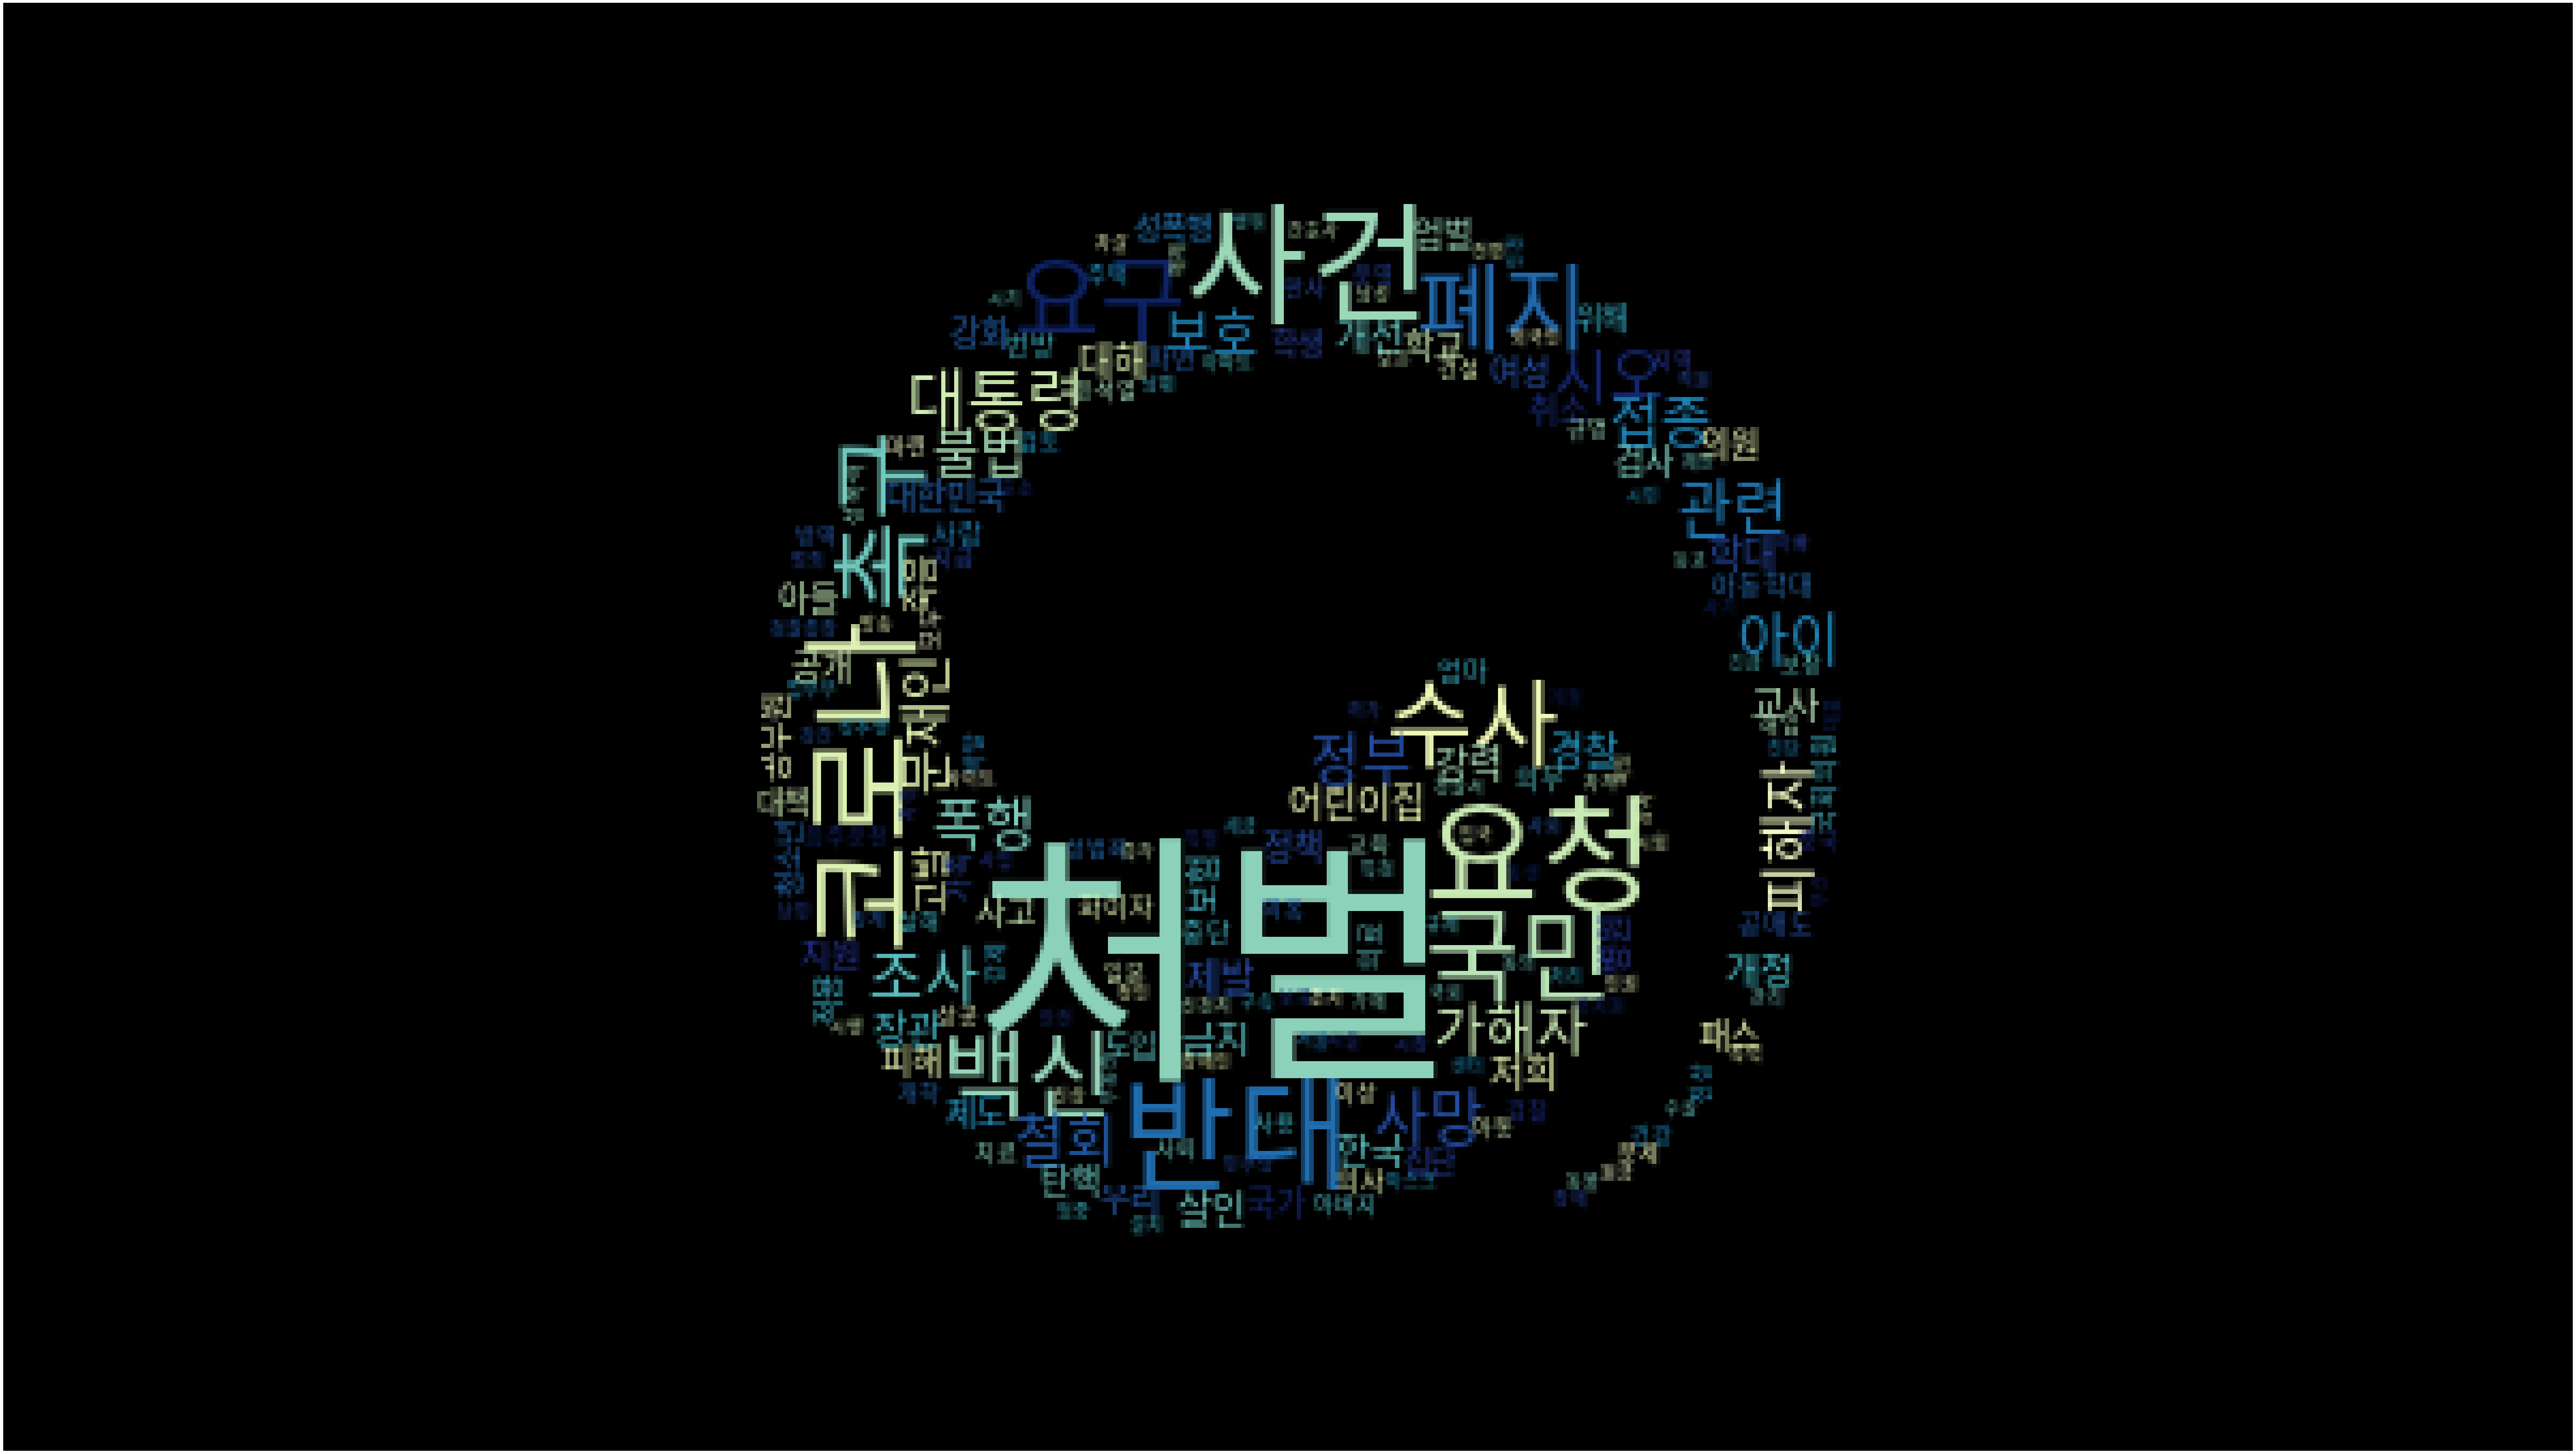

In [193]:
# 워드 클라우드 출력하기
cmap = plt.cm.YlGnBu
mask_korea=np.array(Image.open('태극.jpeg'))

wc = WordCloud(font_path = '/Users/hwangjaewon/Downloads/NotoSansCJKkr-hinted/NotoSansMonoCJKkr-Regular.otf',      
               background_color = "black",  
               max_font_size = 100,         
               margin = 0,                  
               colormap = cmap,
               mask=mask_korea)   
cloud = wc.generate_from_frequencies(word_dict)

#전체 워드클라우드
plt.figure(figsize=(100,100))
plt.imshow(cloud) 
plt.axis("off")
plt.show()

# 특정 키워드로 word2vec 단어 유사도 보기
백신 관련 청원의 내용들의 단어 유사도 확인

In [198]:
# !pip install soynlp
# !pip install gensim

You should consider upgrading via the '/Users/hwangjaewon/anaconda3/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/hwangjaewon/anaconda3/bin/python3 -m pip install --upgrade pip' command.


## 제목에 백신이 포함된 데이터

In [461]:
vaccine=petition_fin[petition_fin['content'].str.contains('백신')]
vaccine=vaccine[:100] #100개만 골라서 진행

In [462]:
vac_list=[]
for i in vaccine['content'].index:
    vac_list.append(vaccine['content'][i])

In [463]:
vac_list

['\n\t\t\t\t\t\t\t\t\t\t저는 대구 수성구에 거주하는 2004년생 현 고2입니다. 지난번에 저도 백신패스 반대 청원이 있어서 동의하기는 했지만, 20만을 채우지도 못한 채 마감된 것이 참 안타깝습니다. 이에 다시 한 번 백신패스 확대 정책을 철회할 것을 강력히 요구하고자 합니다.\n\n안 그래도 위드 코로나가 시행되면서 백신 패스가 도입된 것에 대하여 그리 달갑지 않은 시선이었고 개인적으로도 백신 부작용에 대한 불안 때문에 백신 1차조차 아직까지 맞지 못하고 있는 상황인데, 왜 이렇게 백신패스 확대에만 혈안이 되어 있는지 이해가 가지 않는 것 같습니다. \n\n백신패스를 반대하는 이유 첫 번째는 "돌파감염 건수가 많기 때문"입니다. 백신이라는 것의 정확한 목적은 어떤 질병에 걸리지 않도록 사전에 예방해주는 말 그대로 예방주사나 마찬가지인데, 이렇게 백신을 맞췄는데도 연천 육군부대 집단 돌파감염, 청해부대 돌파감염 사례 등 돌파감염이 심각하게 퍼진 사례가 있기 때문에 백신을 맞았다고 해서 절대 안심할 수가 없다는 결론을 내릴 수 있게 됩니다.\n\n백신패스를 반대하는 이유 두 번째는 "인간으로써의 기본권인 인권 침해이기 때문"입니다. 지금 현재 유통되고 있는 코로나 백신(AZ, 화이자, 모더나, 얀센 등등)의 경우 모든 종류의 백신에서 부작용으로 사망한 사례가 꾸준히 나오고 있으며, 백신 맞고 죽었다는 소식 듣다가 가슴이 철렁거릴 정도입니다. 이렇게 백신 부작용으로 위중증 질병에 걸리거나 사망에 이르는 사례가 계속 나오게 되면 백신에 대한 국민들의 신뢰도는 당연히 하락할 수밖에 없으며 코로나 안 걸리자고 백신 맞다가 오히려 맞고 죽을까 두려워서 접종을 거부하게 되는 것입니다. 사람의 목숨은 단 하나밖에 없고, 백신 맞고 죽는다고 해서 국가에서 보상도 안 해주고 있으며 심지어 인과성 인정조차 안 해주는 사례가 태반인 판국에 이 정도면 당연히 접종을 거부할 권리가 있어야 하는 거 아닌가요? 그리고 더 가관인 게, 지금 이 정부는 부작용이 무섭다는 

## 데이터 토큰화

In [470]:
from konlpy.tag import Kkma
from konlpy.tag import Okt
kkma = Kkma()
okt = Okt()

In [453]:
#토큰화 함수
def tokenizer(raw, pos=["Noun"], stopword=[""]):
    return [
        word for word, tag in okt.pos(
            raw, 
            norm=True,   # normalize 그랰ㅋㅋ -> 그래ㅋㅋ
            stem=True    # stemming 바뀌나->바뀌다
            )
            if len(word) > 1 and tag in pos and word not in stopword
        ]

In [464]:
for text in vac_list :
    common_texts.append(tokenizer(text))

In [465]:
common_texts

['텔레',
 '그램',
 '번방',
 '대한',
 '수사',
 '진행',
 '일부',
 '용의자',
 '검거',
 '다행',
 '이번',
 '텔레그램',
 '통한',
 '미성년',
 '아동',
 '대한',
 '성범죄',
 '절대',
 '재발',
 '경악',
 '범죄',
 '의심',
 '여지',
 '범죄',
 '반드시',
 '재발',
 '가입',
 '구매',
 '아무',
 '처벌',
 '때문',
 '관리자',
 '공급',
 '자만',
 '처벌',
 '소용',
 '관리자',
 '공급',
 '대한',
 '처벌',
 '제대로',
 '형태',
 '범죄',
 '수요',
 '수요',
 '자의',
 '구매',
 '행위',
 '대한',
 '처벌',
 '반드시',
 '재발',
 '희생양',
 '미국',
 '아동',
 '포르노',
 '소지',
 '해도',
 '처벌',
 '반면',
 '우리나라',
 '현실',
 '아동',
 '강간',
 '살인',
 '미수',
 '고작',
 '중형',
 '고작',
 '나라',
 '정도',
 '아동',
 '성범죄',
 '사람',
 '바보',
 '지경',
 '여기',
 '감형',
 '초범',
 '감형',
 '아동',
 '성범죄',
 '과연',
 '아동',
 '성범죄',
 '근절',
 '의지',
 '나라',
 '텔레',
 '그램',
 '가입자',
 '전원',
 '모두',
 '성범죄자',
 '아들',
 '상대로',
 '성범죄',
 '현장',
 '방관',
 '범죄',
 '컨텐츠',
 '동조',
 '범죄',
 '가입자',
 '모두',
 '성범죄자',
 '잠재',
 '성범죄자',
 '그냥',
 '성범죄자',
 '처벌',
 '포함',
 '여자아이',
 '번방',
 '가입자',
 '방금',
 '엽기',
 '변태',
 '성범죄',
 '영상',
 '동조',
 '이입',
 '범죄',
 '변태',
 '싸이코',
 '패쓰',
 '주변',
 '소름',
 '저희',
 '방법',
 '처벌',
 '라면',
 '신상',
 '나라',
 '아이',
 '아동',
 '성범죄자',
 '로부

## Word2Vec 모델 생성

In [466]:
from gensim.models import Word2Vec
model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)

2021-12-09 05:25:35,923 : INFO : collecting all words and their counts
2021-12-09 05:25:35,928 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2021-12-09 05:25:35,930 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-09 05:25:35,946 : INFO : collected 3733 word types from a corpus of 52172 raw words and 382 sentences
2021-12-09 05:25:35,947 : INFO : Loading a fresh vocabulary
2021-12-09 05:25:35,964 : INFO : effective_min_count=1 retains 3733 unique words (100% of original 3733, drops 0)
2021-12-09 05:25:35,966 : INFO : effective_min_count=1 leaves 52172 word corpus (100% of original 52172, drops 0)
2021-12-09 05:25:35,979 : INFO : deleting the raw counts dictionary of 3733 items
2021-12-09 05:25:35,980 : INFO : sample=0.001 downsamples 50 most-common words
2021-12-09 05:25:35,981 : INFO : downsampling leaves estimated 44840 word corpus (85.9% of prior 52172)
2021-12-

In [467]:
model.wv.similar_by_word("마스크")

2021-12-09 05:25:41,946 : INFO : precomputing L2-norms of word weight vectors


[('학교', 0.9999358654022217),
 ('이제', 0.9999322891235352),
 ('아이', 0.9999312162399292),
 ('의무', 0.9999208450317383),
 ('제대로', 0.9999202489852905),
 ('대통령', 0.9999195337295532),
 ('학원', 0.9999191761016846),
 ('조치', 0.999919056892395),
 ('문제', 0.9999188780784607),
 ('모두', 0.9999186992645264)]

In [468]:
model.wv.similar_by_word("정부")

[('대한', 0.9999619126319885),
 ('생각', 0.9999459981918335),
 ('국가', 0.9999445676803589),
 ('때문', 0.9999440908432007),
 ('사람', 0.9999403953552246),
 ('개인', 0.999940037727356),
 ('대해', 0.9999392628669739),
 ('현재', 0.999936580657959),
 ('또한', 0.9999354481697083),
 ('상황', 0.9999332427978516)]

In [469]:
model.wv.similar_by_word("코로나")

[('이유', 0.99993896484375),
 ('상황', 0.9999368786811829),
 ('진자', 0.9999358057975769),
 ('사람', 0.999933123588562),
 ('때문', 0.9999317526817322),
 ('현재', 0.9999296069145203),
 ('효과', 0.9999291300773621),
 ('바이러스', 0.9999268054962158),
 ('대한', 0.9999266862869263),
 ('대해', 0.9999264478683472)]

## 시각화

In [471]:
from sklearn.manifold import TSNE

vocab = list(model.wv.vocab)[:50]
target_word = ["정부", "코로나", "마스크"]
vocab += target_word
vocab = list(set(vocab))
X = model.wv[vocab]

tsne = TSNE(n_components=2, random_state = 5)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

Text(-34.12453079223633, 22.589303970336914, '')

Text(29.164705276489258, -75.25804138183594, '')

Text(4.390252113342285, 10.21215534210205, '')

Text(-25.765871047973633, 59.40099334716797, '')

Text(31.968904495239258, -9.557334899902344, '')

Text(-2.6247522830963135, -1.9060466289520264, '')

Text(-1.0443830490112305, -68.42607116699219, '')

Text(22.8983097076416, -48.37940216064453, '')

Text(-8.307866096496582, 29.27009391784668, '')

Text(-25.699445724487305, 46.89289855957031, '')

Text(0.8504886031150818, -32.346595764160156, '')

Text(-50.56447219848633, 58.55875015258789, '')

Text(17.493358612060547, -35.918643951416016, '')

Text(23.660615921020508, 0.9220279455184937, '')

Text(-48.787330627441406, 28.493488311767578, '')

Text(-24.19685935974121, 34.49223327636719, '')

Text(49.875, -53.93455505371094, '')

Text(10.565665245056152, -0.7319386005401611, '')

Text(18.651369094848633, -12.904447555541992, '')

Text(-14.750955581665039, -9.02898120880127, '')

Text(-19.991514205932617, 22.176902770996094, '')

Text(0.5194516181945801, 55.58266067504883, '')

Text(-12.39841079711914, 42.055625915527344, '')

Text(31.55780601501465, -37.41117858886719, '')

Text(-24.19852638244629, 73.68341827392578, '')

Text(45.4190788269043, -37.68210983276367, '')

Text(5.517160892486572, -12.88815975189209, '')

Text(-51.185211181640625, 43.43966293334961, '')

Text(-13.700035095214844, 54.944664001464844, '')

Text(-5.44947624206543, -19.391660690307617, '')

Text(-13.008540153503418, 6.569949626922607, '')

Text(18.791791915893555, 13.048091888427734, '')

Text(58.00363540649414, -0.34633931517601013, '정부')

Text(23.01879119873047, -61.86823272705078, '')

Text(-37.1445198059082, 38.03993225097656, '')

Text(-6.0896430015563965, 16.835561752319336, '')

Text(11.722160339355469, -24.503957748413086, '')

Text(39.55178451538086, -64.9596176147461, '')

Text(53.02215576171875, 10.2506103515625, '마스크')

Text(-13.62001895904541, -68.52491760253906, '')

Text(2.268738269805908, 39.28125, '')

Text(8.761419296264648, -47.41560363769531, '')

Text(-7.2616167068481445, -80.11637878417969, '')

Text(-38.102928161621094, 67.22631072998047, '')

Text(-37.9398193359375, 51.69784164428711, '')

Text(11.470843315124512, -77.57587432861328, '')

Text(-26.325355529785156, 8.262845039367676, '')

Text(25.70745277404785, -24.571876525878906, '')

Text(35.80038833618164, -51.54735565185547, '')

Text(-9.799335479736328, 68.3057632446289, '')

Text(39.42158508300781, -23.835073471069336, '')

Text(7.186812877655029, 24.29119110107422, '')

Text(-24.702808380126953, -36.61344528198242, '코로나')

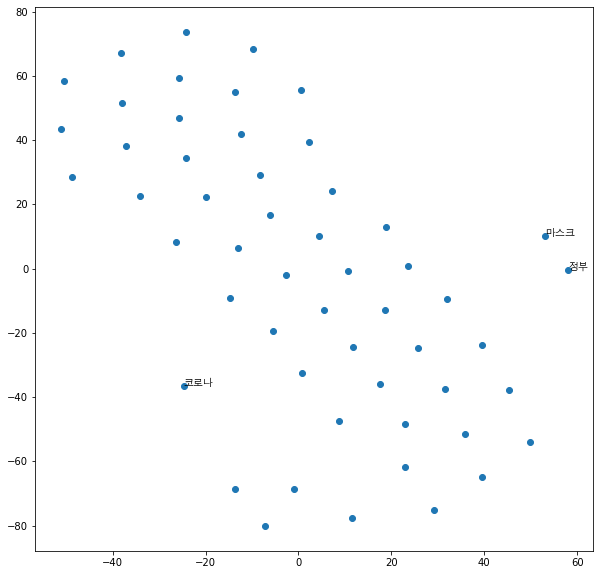

In [474]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.rcParams["font.family"] = 'AppleGothic'
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    if word in target_word:
        ax.annotate(word, pos)
    else:
        ax.annotate("", pos)

# BOW, TF-IDF
앞서 사용한 제목에 '백신' 들어가는 청원에 대한 분석

In [477]:
vaccine.head()

,category,title,end,votes,content,url,word_count
0,보건복지,백신패스(일명 방역패스) 다시 한 번 결사 반대합니다,2021-12-26,334073,\n\t\t\t\t\t\t\t\t\t\t저는 대구 수성구에 거주하는 2004년생 현...,/petitions/602510,2763.0
3,보건복지,아이들까지 백신강요 하지 마세요!,2022-01-05,117788,\n\t\t\t\t\t\t\t\t\t\t오미크론 유입으로 방역 고삐를 좀 조이는가 ...,/petitions/602722,919.0
11,안전/환경,"학원, 도서관, 독서실 백신패스 철회해라 !!!",2022-01-05,32916,"\n\t\t\t\t\t\t\t\t\t\t안녕하세요, 저는 중고등학생을 상대로 학원을...",/petitions/602728,1515.0
14,보건복지,화이자 백신 접종 후 ‘며칠 쉬다 갈게’ 하고는 별이 된 남편,2021-12-17,28104,\n\t\t\t\t\t\t\t\t\t\t대구광역시에 사는 4명의 아이를 둔 다둥이 ...,/petitions/602362,3677.0
15,보건복지,유은혜 교육부 장관 자격 박탈을 요구합니다,2022-01-02,28047,\n\t\t\t\t\t\t\t\t\t\t예전에 고2 백신패스 반대 청원을 올린 해당...,/petitions/602684,1646.0


## Data cleansing

In [475]:
def preprocessing(text):
    text = re.sub('\\\\n', ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    text = re.sub(' +', ' ', text)
    return text

In [492]:
def remove_stopwords(text):
    stops = ['http']
    meaningful_words = [w for w in text if not w in stops]
    return ''.join(meaningful_words)

In [493]:
%time vaccine['content_preprocessing'] = vaccine['content'].apply(preprocessing).apply(remove_stopwords)
sentences = vaccine['content_preprocessing']
sentences.shape

CPU times: user 57.1 ms, sys: 3.65 ms, total: 60.7 ms
Wall time: 59.1 ms


(100,)

In [494]:
sentences.head()

0      저는 대구 수성구에 거주하는 년생 현 고 입니다 지난번에 저도 백신패스 반대 청원...
3      오미크론 유입으로 방역 고삐를 좀 조이는가 싶었는데 역시 그 놈의 지긋지긋한 검토...
11     안녕하세요 저는 중고등학생을 상대로 학원을 운영하는 사람입니다 오늘 나온 대책 중...
14     대구광역시에 사는 명의 아이를 둔 다둥이 엄마입니다 백신으로 사망한 남편의 억울함...
15     예전에 고 백신패스 반대 청원을 올린 해당 학생 본인입니다 최근에 교육부 장관께서...
Name: content_preprocessing, dtype: object

## BOW(bag of words)
각 단어가 이 말뭉치에 얼마나 많이 나타나는지 고려

In [495]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, 
                             ngram_range=(1, 3), # BOW의 단위 지정
                             max_features = 1000 # 만들 피처의 수
                            )
vectorizer

CountVectorizer(max_features=1000, min_df=2, ngram_range=(1, 3))

In [496]:
feature_vector = vectorizer.fit_transform(vaccine['content_preprocessing'])
feature_vector.shape

(100, 1000)

In [497]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

1000


['https', 'pcr', '가는', '가능성이', '가벼운', '가서', '가슴', '가운데', '가장', '가족']

In [498]:
# 벡터화 된 피처를 확인
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)
pd.DataFrame(dist, columns=vocab)

,https,pcr,가는,가능성이,가벼운,가서,가슴,가운데,가장,가족,...,회사,효과가,효과에,후에,후유증,훨씬,힘든,힘들게,힘들어,힘을
0,6,15,13,6,6,17,8,7,34,13,...,8,19,7,9,7,7,9,6,6,6


## TF-IDF
:TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값

In [500]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [501]:
%%time 
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

CPU times: user 6.35 ms, sys: 11.8 ms, total: 18.2 ms
Wall time: 27 ms


(100, 1000)

In [503]:
dist = np.sum(feature_tfidf, axis=0)
# 단어와 함께 볼 수 있도록    
for tag, count in zip(vocab, dist):
    print(count, tag)
    
pd.DataFrame(dist, columns=vocab)

[[0.32471539 1.09429694 0.68306952 0.30157411 0.44358901 0.95664281
  0.63620518 0.59451763 1.44047931 0.67096613 0.44459003 0.54228749
  0.56661667 0.57807877 0.65915263 1.12217761 0.91157726 0.36114293
  0.29986989 0.5082334  0.41278623 0.54872031 0.975161   0.59482425
  0.30798674 0.30471546 1.84115955 0.59476443 0.34485351 0.86101465
  0.70750385 0.71306892 0.69155651 1.4745987  1.79576099 0.78756673
  0.41491829 0.29564486 0.49139634 0.96845883 0.41544259 0.50271949
  0.92375598 0.71949015 0.42451033 0.64692702 0.41186548 1.01944717
  0.69289257 0.95109308 1.35972448 0.50024591 0.51354403 0.37747816
  0.73819401 0.5298664  1.00889709 0.53281775 2.63128496 1.70402087
  2.47708907 0.52231835 0.52935277 0.38715624 0.53852356 0.36395333
  0.66666626 2.78036318 0.61040953 0.97498359 0.97498359 0.97498359
  0.55167143 0.29679037 0.58502764 0.79539991 0.60747999 0.7419809
  0.59571474 1.15554575 0.51097013 1.62819359 0.56242994 0.32930869
  1.71680159 0.47258252 0.71075912 0.4513969  0.7

,https,pcr,가는,가능성이,가벼운,가서,가슴,가운데,가장,가족,...,회사,효과가,효과에,후에,후유증,훨씬,힘든,힘들게,힘들어,힘을
0,0.324715,1.094297,0.68307,0.301574,0.443589,0.956643,0.636205,0.594518,1.440479,0.670966,...,0.623932,1.082597,0.413797,0.760204,0.551121,0.504196,0.738255,0.54553,0.599541,0.305012
